In [1]:
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from functools import lru_cache
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

In [2]:
# def process():
#     def traj_path(i):
#         return os.path.join('../nohup_output/nav_vacuum_rf_edison_1_traj', f'trajectory_49032_{i}.npy')
#     def save_path(i):
#         return os.path.join('../nohup_output/nav_vacuum_rf_edison_1_traj', f'trajectory_{i}')
#     def num_outside(objs_pos):
#         return np.sum(np.sum(np.square(objs_pos), axis=1) > 30 ** 2)
    
#     num_grasped = -1
#     for i in range(1, 102):
#         traj = np.load(traj_path(i), allow_pickle=True)[()]
#         new_blocks = OrderedDict()
#         for t in sorted(traj['objects'].keys()):
#             objs = traj['objects'][t]
#             n = num_outside(objs)
#             if n > num_grasped: 
#                 new_blocks[t] = objs
#                 num_grasped = n
#         traj['objects'] = new_blocks
#         np.save(save_path(i), traj)

# process()

In [2]:
# def traj_path(i):
#     return os.path.join('../nohup_output/nav_vacuum_perturbation_edison_1_traj', f'trajectory_186460_{i}.npy')
#     return os.path.join('../nohup_output/nav_vacuum_perturbation_edison_3_traj', f'trajectory_538151_{i}.npy')
#     return os.path.join('../nohup_output/test_point_grid_exploration_edison_1_traj', f'trajectory_97181_{i}.npy')

def get_all_trajectories(folder, uid=None):
    if uid is None:
        uid = "*"
    else:
        uid = str(uid)
        
    filenames = glob.glob(os.path.join(folder, f"trajectory_{uid}_*.npy"))
    
    all_trajectories = OrderedDict()
    for filename in filenames:
        trajectories = np.load(filename, allow_pickle=True)[()]
        all_trajectories.update(trajectories)
        
    return all_trajectories

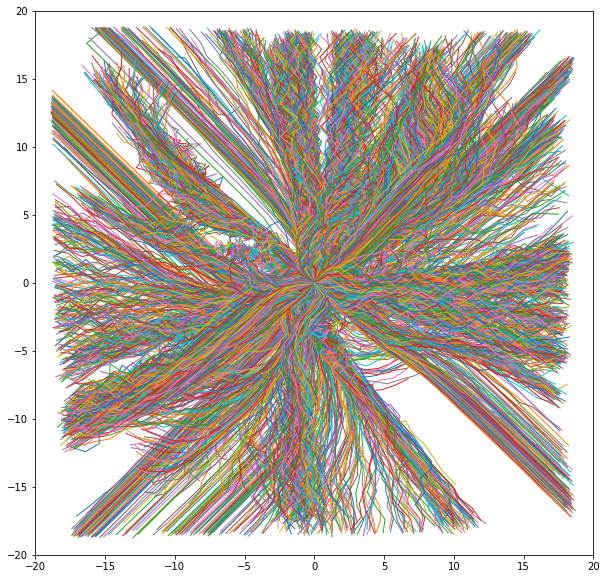

In [4]:
folder = '../nohup_output/test_point_grid_exploration_edison_21_traj'

trajs = get_all_trajectories(folder)

def plot_traj(traj):
    x = traj[:, 0]
    y = traj[:, 1]
    plt.plot(x, y, lw=1)

plt.figure(figsize=(10, 10))
plt.xlim((-20, 20))
plt.ylim((-20, 20))

# for i in range(0, 100):
for i in sorted(trajs.keys()):
    plot_traj(trajs[i])

In [68]:
max(trajs.keys())

4999

(100000, 2)
[-20.0, 20.0, -20.0, 20.0]


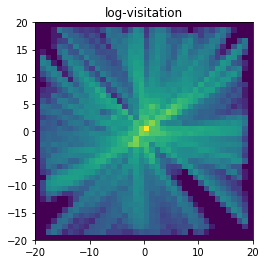

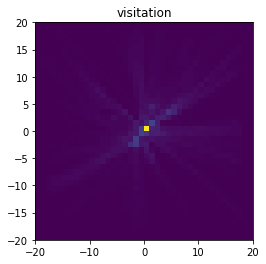

In [7]:
folder = '../nohup_output/test_point_grid_exploration_edison_21_traj'

trajs = get_all_trajectories(folder)
points = np.concatenate(list(trajs.values()))
print(points.shape)

points = points[np.max(np.abs(points), axis=1) >= 0]

x, y = points[:, 0], points[:, 1]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=40, range=[[-20, 20], [-20, 20]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

log_heatmap = np.log(heatmap.T + 1)
log_heatmap = (log_heatmap - np.min(log_heatmap)) / np.ptp(log_heatmap)

plt.clf()
plt.title("log-visitation")
plt.imshow(log_heatmap, extent=extent, origin='lower')
plt.show()

plt.clf()
plt.title("visitation")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [8]:
from softlearning.rnd import rnd_predictor_and_target
import tensorflow as tf

rnd_predictor, rnd_target = rnd_predictor_and_target(
    input_shapes={'observations': tf.TensorShape((2,))},
    output_shape=(512,),
    hidden_layer_sizes=(512, 512),
    activation='relu',
    output_activation='linear',
)
rnd_predictor.load_weights(os.path.join(folder, 'rnd_predictor'))
rnd_target.load_weights(os.path.join(folder, 'rnd_target'))

In [9]:
def midlinspace(a, b, n):
    return np.linspace(a, b, n * 2 + 1)[1::2]
    
losses = np.zeros((40, 40))
for ix, x in enumerate(midlinspace(-20, 20, 40)):
    for iy, y in enumerate(midlinspace(-20, 20, 40)):
        observations = {'observations': np.array([[x, y]])}
        predictor_values = rnd_predictor.values(observations)
        target_values = rnd_target.values(observations)
        loss = tf.losses.MSE(y_true=target_values, y_pred=predictor_values).numpy().squeeze()[()]
        losses[ix, iy] = loss

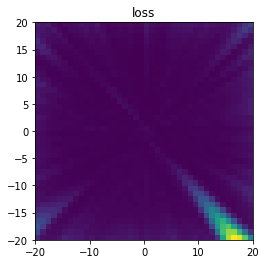

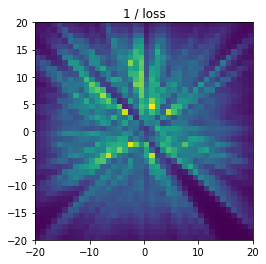

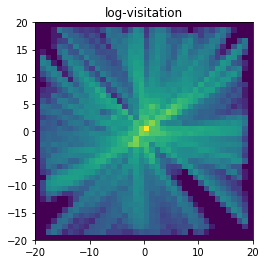

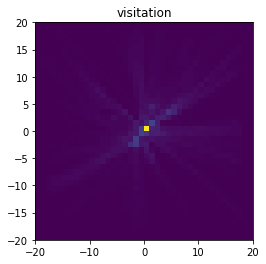

In [10]:
plt.clf()
plt.title("loss")
plt.imshow(losses.T, extent=[-20, 20, -20, 20], origin='lower')
plt.show()

plt.clf()
plt.title("1 / loss")
plt.imshow(1. / losses.T, extent=[-20, 20, -20, 20], origin='lower')
plt.show()

plt.clf()
plt.title("log-visitation")
plt.imshow(log_heatmap, extent=extent, origin='lower')
plt.show()

plt.clf()
plt.title("visitation")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

frames: 501
total seconds: 50.1


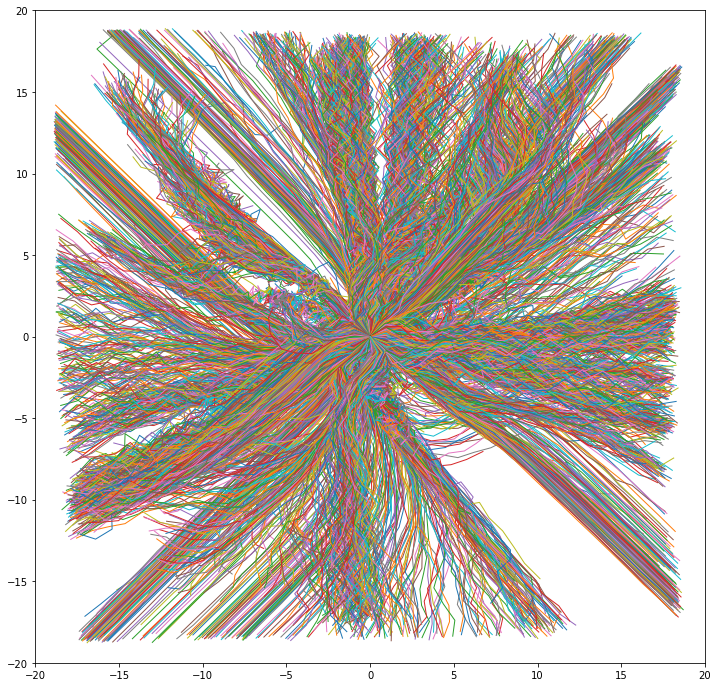

In [11]:
folder = '../nohup_output/test_point_grid_exploration_edison_21_traj'

trajs = get_all_trajectories(folder)

def plot_traj(traj):
    x = traj[:, 0]
    y = traj[:, 1]
    plt.plot(x, y, lw=1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.set_xlim((-20, 20))
ax.set_ylim((-20, 20))
# fig.suptitle("nav_vacuum_rf_edison_1_traj")

episodes = list(range(0, 5000))
episodes_per_frame = 10
interval = 100

print("frames:", len(episodes)//episodes_per_frame+1)
print("total seconds:", (len(episodes)//episodes_per_frame+1) * interval / 1000)

lines = {}
for ep in episodes:
    line, = ax.plot([], [], lw=1)
    lines[ep] = line

def init():
    for ep in episodes:
        lines[ep].set_data([], [])
    return [lines[ep] for ep in episodes]

def animate(i):
    eps = episodes[i * episodes_per_frame: (i + 1) * episodes_per_frame]
    for ep in eps:
        traj = trajs[ep]
        x = traj[:, 0]
        y = traj[:, 1]
        lines[ep].set_data(x, y)
    
    return [lines[ep] for ep in eps]

import time

start = time.time()

# anim = FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)
anim = FuncAnimation(fig, animate, init_func=init, frames=len(episodes)//episodes_per_frame+1, interval=interval, blit=True)
HTML(anim.to_html5_video())
# anim.save("../nohup_output/nav_vacuum_rf_edison_1_traj.mp4")

In [21]:
a = OrderedDict()

In [22]:
a[1] = 2

In [23]:
a[4] = 3

In [24]:
a[9] = 4

In [25]:
a

OrderedDict([(1, 2), (4, 3), (9, 4)])